# Task 1 - Shilling Detection
-----

In [0]:
from scipy import stats
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [0]:
movies = pd.read_csv('/content/drive/My Drive/Interview Tasks/Task 1 Resources/movies.csv')
ratings = pd.read_csv('/content/drive/My Drive/Interview Tasks/Task 1 Resources/ratings.csv')
users = pd.read_csv('/content/drive/My Drive/Interview Tasks/Task 1 Resources/users.csv')

In [0]:
movies_ratings = pd.merge(movies, ratings, left_on='Id', right_on='MovieID')
movies_ratings_users = pd.merge(movies_ratings, users, left_on='UserID', right_on='UserID')

In [4]:
D = movies_ratings_users.pivot_table(index='UserID', columns='MovieID', values='Rating')
# D = D.apply(lambda x: x.fillna(0), axis=0)
# D = D.astype(int)
D.head()

MovieID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,4.0,NaN,3.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
D.describe()

MovieID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
count,2072.000000,701.000000,477.000000,170.000000,294.000000,939.000000,456.000000,68.000000,102.000000,887.000000,1030.000000,160.000000,99.000000,153.000000,146.000000,681.000000,834.000000,157.000000,389.000000,160.000000,1354.000000,378.000000,126.000000,622.000000,980.000000,100.000000,61.000000,179.000000,403.000000,73.000000,141.000000,1509.000000,4.000000,1748.00000,70.000000,928.000000,8.000000,28.000000,1361.000000,30.000000,...,32.000000,70.000000,127.000000,437.000000,279.000000,167.000000,87.000000,66.000000,47.000000,39.000000,104.000000,26.000000,124.000000,180.000000,348.000000,206.000000,147.000000,223.000000,27.000000,232.000000,16.000000,28.000000,23.000000,112.000000,135.000000,27.000000,26.000000,15.000000,22.000000,28.000000,96.000000,9.000000,43.000000,100.000000,55.000000,861.000000,304.000000,54.000000,40.000000,386.000000
mean,4.144788,3.201141,3.014675,2.729412,2.996599,3.877529,3.410088,3.014706,2.656863,3.540023,3.793204,2.362500,3.262626,3.542484,2.458904,3.794420,4.027578,3.337580,2.480720,2.537500,3.621861,3.349206,2.857143,3.181672,3.651020,3.530000,2.934426,4.055866,4.062035,3.643836,3.113475,3.944334,3.000000,3.89016,3.314286,3.957974,3.500000,2.821429,3.623806,3.933333,...,2.906250,3.328571,3.511811,3.924485,3.111111,2.802395,2.229885,3.712121,2.638298,2.589744,2.576923,2.923077,3.854839,3.361111,3.580460,3.441748,3.993197,3.255605,2.037037,3.750000,2.250000,3.035714,3.000000,3.723214,2.940741,1.925926,1.961538,1.733333,2.045455,1.785714,3.052083,2.111111,1.488372,2.260000,3.472727,3.635308,4.115132,3.666667,3.900000,3.779793
std,0.852345,0.983172,1.071888,1.013381,1.020267,0.934369,0.981492,0.954059,1.048290,0.891602,0.864454,1.205269,1.055461,0.873491,1.221230,0.905229,0.905078,1.016241,1.178748,0.903435,0.934038,0.977064,1.001713,1.068108,1.093508,0.947671,0.980966,0.872299,0.996822,1.018848,0.964307,0.963981,0.816497,1.03817,0.909576,0.867339,1.414214,1.467009,0.963827,0.868345,...,1.573149,1.176108,1.220630,0.991371,1.243046,1.131368,0.996519,1.106139,1.168900,1.271509,0.982293,1.128648,1.009657,0.810296,0.822499,1.074768,0.968664,1.078935,1.018350,0.910497,1.238278,1.231745,0.953463,0.861696,0.853115,1.071517,1.310901,1.279881,1.252703,1.133893,1.251271,1.364225,1.032152,1.078907,1.184069,1.014710,1.009804,1.046107,1.057331,0.934591
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,1.000000,3.000000,3.000000,1.000000,3.000000,4.000000,3.000000,1.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,4.000000,4.000000,3.000000,3.000000,3.000000,2.750000,3.00000,3.000000,3.000000,2.750000,1.750000,3.000000,4.000000,...,1.000000,3.000000,3.000000,3.000000,2.000000,2.000000,1.000000,3.000000,2.000000,1.500000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.500000,3.000000,1.000000,3.000000,1.000000,2.000000,2.000000,3.000000,2.500000,1.000000,1.000000,1.000000,1.000000,1.0000

# Problem Definiton

In this section basic concepts are defined in order to gain understanding of shilling attacks. After that a PCA based shilling attack detection model is introduced followed by common evaluation metrics being used in this area.

## Definitions

A user-item rating matrix includes three components; users, items and ratings. To put it more precisely,

$U = \lbrace u_{1}, u_{2}, u_{3}, \dots u_{n} \rbrace$

where $U$ is users set, $n$ is the number of users. Also

$I = \lbrace I_{1}, I_{2}, I_{3}, \dots I_{m} \rbrace$

where $I$ is the set of all items and $m$ is the number of items. User profile $P$ consists of all the ratings given by this user. if profile rating are generated by a normal user, the profile is determined to be a genuine profile. Conversely, if a profile is forged, the profile is identified as an attack profile. User-item rating matrix D is the set of all user profiles (all ratings where $r_{nm}$ is the rating score given (from 1–5) by User $n$ on Item $m$. It might be noteworthy that if a user has not rated an item, $r_{nm}$ is set to 0. A user profile consists of all the rated items (1-5) and all the non rated items (0). An attack profile is a type of user profile with forged ratings. Attack profiles contain filler items, selected items, unrated items and target item(s); The selected items are determined by the attacker to form characteristics of the attack; For example, filler items are chosen randomly, but unrated items are also present. The target item is the item that an attacker attempts to push or nuke.
Fig 1. show the composition of an attack profile.

![The general composition of an attack profile.](https://drive.google.com/uc?id=1XCyou5e8U978KXm1lZgQshJRufIcSs-P)

In order to make detection of attack profiles become harder, attackers try to forge ratings to match those of genuine profiles. Based on attack profiles structure different attack models are defined. Based on the goal of attackers they try to push or nuke an target item. These two are defined as:

*   Nuke attacks: aimed on boosting target item and increasing its rank.
*   Push attacks: designed to downgrade target item and decrease its rank.

In this project I assumed that shilling profiles intend to push the target item.



## Shilling attack models

Based on attackers' knowledge and usage, three mainly popular attack models have been identified: random, average and bandwagon models. In general there are 3 parts in a profile: target item set $I_{T}$, Selected set $I_{S}$; attackers usually select some items that have simillar characteristics with a target item; and filler set $I_{F}$, which is a selection of items that make the attack profile be similar to normal ones.

Table 1. shows the composition of each attack model.

Attack Model | $I_{S}$(Selected Set) | $I_{F}$(Filler Set) | $I_{T}$(Target Set)
--- | --- | --- | ---
Random | $\emptyset$ | random selected | $r_{max}/r_{min}$
Average | $\emptyset$ | mean of items | $r_{max}/r_{min}$
<!-- Bandwagon | $r_{max}$ | popular items | $r_{max}/r_{min}$ -->
Table 1. Feature of attack models.

*   Random
    
    Random attack uses a normal distribution to evaluate randomly choose filler items around the system’s average ratings. Highest or lowest score are assigned to target item according to attack types (nuke or push).
*   Average

    The average attack requires priori knowledge of average rating of items in the recommender system. Normal distribution is used to randomly rate items with the average score set as the mean rating of items according to the standard deviation. In this attack model, attackers simulate genuine users behaviour to have greater impact on the recommender system. Also detecting attackers requires harder work. The target item is rated as same as random model.
<!-- * Bandwagon

    In this attack model, shilling profiles select a lot of items of certain kind e.g. popular or high rated items. Selected items in bandwagon attack is group attack. The idea behind a group attack is that attackers focus on the users who are already into some product. Attacker's goal is to promote target item not to all users, but some subset of them with a specific property. -->



In [0]:
max_vote = 5
min_vote = 1

# M items
M = D.T.shape[0]
# N users
N = D.T.shape[1]



def random_attack(attack_size, filler_size, target_item_index = 2020):
  nshilling_profiles = attack_size #int(N*attack_size)
  nfiller_items = int(M*filler_size)

  shilling_profiles = []

  # Target item
  target_item_index = target_item_index
  # Non voted items
  non_voted_items_indices = []

  for _ in range(0, nshilling_profiles):
    shilling_profile = np.full((M, 1), 0)
    # Filler items
    filler_items_indices = random.sample(range(M), nfiller_items)
    for filler_item_index in filler_items_indices:
      shilling_profile[filler_item_index, 0] = random.randint(min_vote, max_vote)
    shilling_profiles.append(shilling_profile)
    shilling_profile[target_item_index, 0] = max_vote

  return shilling_profiles


def average_attack(attack_size, filler_size, target_item_index = 2020):
  nshilling_profiles = attack_size #int(N*attack_size)
  nfiller_items = int(M*filler_size)

  shilling_profiles = []

  # Target item
  target_item_index = target_item_index
  # Non voted items
  non_voted_items_indices = []

  for _ in range(0, nshilling_profiles):
    shilling_profile = np.full((M, 1), np.nan)
    # Filler items
    filler_items_indices = random.sample(range(M), nfiller_items)
    for filler_item_index in filler_items_indices:
      shilling_profile[filler_item_index, 0] = np.nanmean(D.to_numpy()[:, filler_item_index])
    shilling_profiles.append(shilling_profile)
    shilling_profile[target_item_index, 0] = max_vote

  return shilling_profiles

def bandwagon_attack(attack_size, filler_size, target_item_index = 2020):
  nshilling_profiles = int(N*attack_size)
  nfiller_items = int(M*filler_size)

  return 'TODO'

## An important charachteristic of shilling profiles

Shillers tend to have very high correlation coefficients(>0.9) due to same underlying attack model that is being used to generate them. Average and random attacks have been observed to have this characterstic.

In [0]:
def plot_corr_matrix(authentic_profiles, shilling_profiles):
  aps_sps_subset = np.concatenate((authentic_profiles, shilling_profiles), axis=0)
  df = pd.DataFrame(np.transpose(aps_sps_subset))
  df_corr = df.corr(method='pearson')
  plt.imshow(df_corr)
  plt.title('Shillers are highly correlated')

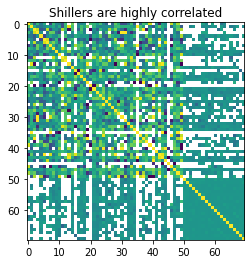

In [8]:
sps = random_attack(attack_size=600, filler_size=0.01, target_item_index=1996)
sps = np.asarray(sps)
sps = np.reshape(sps, (sps.shape[0], sps.shape[1]))

aps_sps = np.concatenate((D.to_numpy(), sps), axis=0)

plot_corr_matrix(aps_sps[0:50, :], aps_sps[6040:6060, :])

50 authentic and 20 shilling profiles (generated by the random attack model) are used to calculate Pearson's Correlation coefficient. It can be seen that shillers (50-70) are highly correlated.

# PCA for shilling detection

Experimental results show that shilling users have very high similarity to one another, and thus might form a cluster. Attacker design shilling users to be similar to other normal users and this makes difficulties to clustering problem.
We try to discover highly correlated users which turn to be shilling ones.

So our aim is to disocer the high correlation between these shilling users. *Principal Component Analysis*(PCA) is a dimensionality reduction technique that project high dimenional data to the lower dimension in where axes capture the maximum varitaion in data. So if dataset has variables that are highly correlated to each other, PCA ignore those and thos who are less correlated reside.

If we cas users as variables (dimensions) dimensionality reduction by PCA would discard these dimensions since their covariance will be low. So we have to select users which show low covariance with others. This Lead to variable selection method defined below which do the job for us.

## Variable selection using PCA

The eigenvector corresponding to the largest eigenvalue is known as the first principal component, and so on. For every variable, each PC contains a coefficient. We choose those users which have the smallest coefficient in the first m PCs (here `m` = 3).


Algoritm ```pca_select_users``` outlines the approach for variable selection. ```PCA``` centeres the input data before applying SVD.  Next NaN values are replaced with zero and data is transposed to cast users as variables. ```pca.compontents_``` yields the principal components; for every variable, each PC contains a coefficient. users are chosen based on more than one PC; typically the coefficients in the first ```m``` PCs.


In [0]:
def pca_select_users(D, m=3):
  pca = PCA(n_components=m)
  pca.fit(np.transpose(np.nan_to_num(D)))
  components = pca.components_
  distances = np.sum(np.abs(components), axis=0)
  
  return distances

# Experiments

In this section experimental results of the PCA based shilling attack detecion  on the MovieLens dataset which consists of 6040 users and 3707 ratings are provided. Also common evaluation metrics for this problem is also introduced and defined.

## Experiment setup

The MovieLens dataset were published by GroupLens is used in the experiments. A rating score of 0 means that there is no user rating for the corresponding item.

## Evaluation Metrics

*Detection Rate* and *False Positive rate* are used to evaluate the proposed method.

*Attacks* is the number of attacks while *Detection* is the number of detected profiles.

>$Detection~Rate = \frac{\#Detection}{\#Attacks}$

*FalsePositives* is the number of misjudged genuine profiles while *GenuineProfiles* is the number of genuine profiles.

> $False~Positive~Rate = \frac{\#False~Positives}{\#Genuine~Profiles}$


In [0]:
def detection_rate(nattacks, distances):
  ndetection = 0
  sorted_users_distances_indices = np.argsort(distances)
  for user_distance_index in sorted_users_distances_indices[0:nattacks]:
    if user_distance_index >= 6040 and user_distance_index <= 6040+nattacks:
      ndetection += 1
      
  return float(ndetection/nattacks)

In [0]:
def false_positive_rate(nattacks, distances):
  nmisjudged_genuine_profiles = 0
  ngenuine_profiles = 6040
  sorted_users_distances_indices = np.argsort(distances)
  for user_distance_index in sorted_users_distances_indices[0:nattacks]:
    if user_distance_index <= 6040:
      nmisjudged_genuine_profiles += 1

  return float(nmisjudged_genuine_profiles/ngenuine_profiles)

## Experimental results

Here I generate attack profiles according to the composition of different attack models based on the two varying parameters (attack size and filler size). Attack and filler sizes used in the experiment are ranging from 60 t0 600 and 1% to 15%, repectively. Also the target item index is set as 1996 (my brith year  :D).

### Random Attack

In [0]:
attack_sizes = [60, 190, 450, 600]
filler_sizes = [0.01, 0.03, 0.05, 0.07, 0.10, 0.15]

detection_rate_matrix = np.empty((len(attack_sizes), len(filler_sizes)))
false_positive_rate_matrix = np.empty((len(attack_sizes), len(filler_sizes)))

for attack_size in attack_sizes:
  for filler_size in filler_sizes:
    shilling_profiles = random_attack(attack_size=attack_size, filler_size=filler_size, target_item_index=1996)
    shilling_profiles = np.asarray(shilling_profiles)
    shilling_profiles = np.reshape(shilling_profiles, (shilling_profiles.shape[0], shilling_profiles.shape[1]))
    D_extended = np.concatenate((D.to_numpy(), shilling_profiles), axis=0)
    distances = pca_select_users(D_extended, 3)
    detection_rate_matrix[attack_sizes.index(attack_size), filler_sizes.index(filler_size)] = detection_rate(attack_size, distances)
    false_positive_rate_matrix[attack_sizes.index(attack_size), filler_sizes.index(filler_size)] = false_positive_rate(attack_size, distances)

In [13]:
print(detection_rate_matrix)

[[0.83333333 0.65       0.5        0.46666667 0.31666667 0.15      ]
 [0.91052632 0.77894737 0.72105263 0.61578947 0.55263158 0.45263158]
 [0.95111111 0.88222222 0.8        0.74       0.67111111 0.56222222]
 [0.95333333 0.89666667 0.83333333 0.78166667 0.695      0.62      ]]


In [14]:
detection_rate_df = pd.DataFrame(detection_rate_matrix, 
                                 index=[i for i in attack_sizes], 
                                 columns=[i for i in filler_sizes])
detection_rate_df = detection_rate_df.style.format("{:.0%}").set_caption(
    'Random attack detection rate based on different attack and filler sizes')
detection_rate_df

,0.01,0.03,0.05,0.07,0.1,0.15
60,83%,65%,50%,47%,32%,15%
190,91%,78%,72%,62%,55%,45%
450,95%,88%,80%,74%,67%,56%
600,95%,90%,83%,78%,70%,62%


In [15]:
print(false_positive_rate_matrix)

[[0.00182119 0.00364238 0.00496689 0.00546358 0.00695364 0.00844371]
 [0.00298013 0.00711921 0.00877483 0.01208609 0.01423841 0.01738411]
 [0.00380795 0.0089404  0.01490066 0.01937086 0.02466887 0.03278146]
 [0.00480132 0.01043046 0.01672185 0.02168874 0.03046358 0.03791391]]


In [16]:
false_positive_rate_df = pd.DataFrame(false_positive_rate_matrix, 
                                 index=[i for i in attack_sizes], 
                                 columns=[i for i in filler_sizes])
false_positive_rate_df = false_positive_rate_df.style.format("{:.0%}").set_caption(
    'Random attack false positive rate based on different attack and filler sizes')
false_positive_rate_df

,0.01,0.03,0.05,0.07,0.1,0.15
60,0%,0%,0%,1%,1%,1%
190,0%,1%,1%,1%,1%,2%
450,0%,1%,1%,2%,2%,3%
600,0%,1%,2%,2%,3%,4%


Two figures below shows detection rate and false positive rate of pca based shilling detection for random attack shilling model.

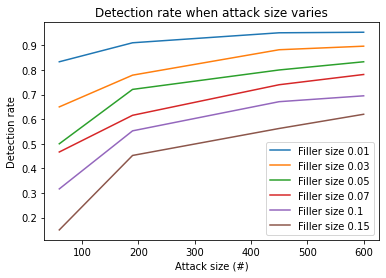

In [17]:
# Create a figure and an axes.
fig1, ax1 = plt.subplots()

for index in range(0, len(filler_sizes)):
  ax1.plot(np.asarray(attack_sizes), detection_rate_matrix[:, index], 
           label='Filler size '+str(filler_sizes[index]).format("{:.0%}"))

# Add an x-label to the axes.
ax1.set_xlabel('Attack size (#)')
# Add a y-label to the axes.
ax1.set_ylabel('Detection rate')
# Add a title to the axes.
ax1.set_title("Detection rate when attack size varies")
ax1.legend()

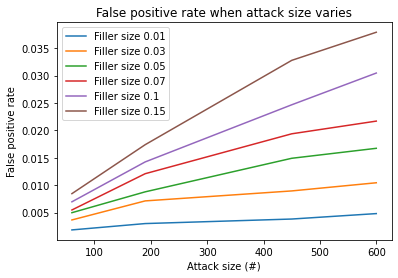

In [18]:
# Create a figure and an axes.
fig2, ax2 = plt.subplots()

for index in range(0, len(filler_sizes)):
  ax2.plot(np.asarray(attack_sizes), false_positive_rate_matrix[:, index], 
           label='Filler size '+str(filler_sizes[index]).format("{:.0%}"))

# Add an x-label to the axes.
ax2.set_xlabel('Attack size (#)')
# Add a y-label to the axes.
ax2.set_ylabel('False positive rate')
# Add a title to the axes.
ax2.set_title("False positive rate when attack size varies")
ax2.legend()



---



### Average Attack

In [0]:
attack_sizes = [60, 190, 450]
filler_sizes = [0.01, 0.03, 0.05]

detection_rate_matrix = np.empty((len(attack_sizes), len(filler_sizes)))
false_positive_rate_matrix = np.empty((len(attack_sizes), len(filler_sizes)))

for attack_size in attack_sizes:
  for filler_size in filler_sizes:
    shilling_profiles = average_attack(attack_size=attack_size, filler_size=filler_size, target_item_index=1996)
    shilling_profiles = np.asarray(shilling_profiles)
    shilling_profiles = np.reshape(shilling_profiles, (shilling_profiles.shape[0], shilling_profiles.shape[1]))
    D_extended = np.concatenate((D.to_numpy(), shilling_profiles), axis=0)
    distances = pca_select_users(D_extended, 3)
    detection_rate_matrix[attack_sizes.index(attack_size), filler_sizes.index(filler_size)] = detection_rate(attack_size, distances)
    false_positive_rate_matrix[attack_sizes.index(attack_size), filler_sizes.index(filler_size)] = false_positive_rate(attack_size, distances)

In [20]:
print(detection_rate_matrix)

[[0.73333333 0.53333333 0.33333333]
 [0.86315789 0.68421053 0.52631579]
 [0.93111111 0.78666667 0.63333333]]


In [21]:
detection_rate_df = pd.DataFrame(detection_rate_matrix, 
                                 index=[i for i in attack_sizes], 
                                 columns=[i for i in filler_sizes])
detection_rate_df = detection_rate_df.style.format("{:.0%}").set_caption(
    'Average attack detection rate based on different attack and filler sizes')
detection_rate_df

,0.01,0.03,0.05
60,73%,53%,33%
190,86%,68%,53%
450,93%,79%,63%


In [22]:
print(false_positive_rate_matrix)

[[0.00281457 0.00463576 0.00662252]
 [0.0044702  0.01009934 0.01490066]
 [0.00529801 0.0160596  0.02748344]]


In [23]:
false_positive_rate_df = pd.DataFrame(false_positive_rate_matrix, 
                                 index=[i for i in attack_sizes], 
                                 columns=[i for i in filler_sizes])
false_positive_rate_df = false_positive_rate_df.style.format("{:.0%}").set_caption(
    'Average attack false positive rate based on different attack and filler sizes')
false_positive_rate_df

,0.01,0.03,0.05
60,0%,0%,1%
190,0%,1%,1%
450,1%,2%,3%


Two figures below shows detection rate and false positive rate of pca based shilling detection for average attack shilling model.

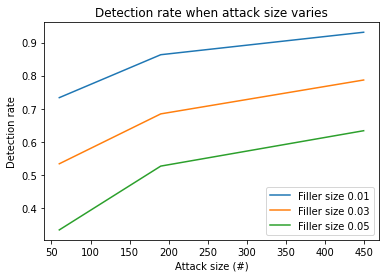

In [24]:
# Create a figure and an axes.
fig1, ax1 = plt.subplots()

for index in range(0, len(filler_sizes)):
  ax1.plot(np.asarray(attack_sizes), detection_rate_matrix[:, index], 
           label='Filler size '+str(filler_sizes[index]).format("{:.0%}"))

# Add an x-label to the axes.
ax1.set_xlabel('Attack size (#)')
# Add a y-label to the axes.
ax1.set_ylabel('Detection rate')
# Add a title to the axes.
ax1.set_title("Detection rate when attack size varies")
ax1.legend()

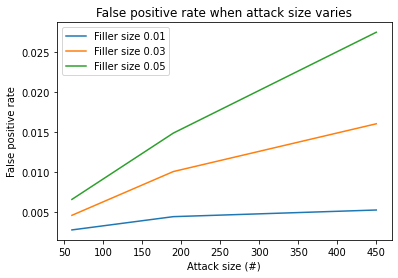

In [25]:
# Create a figure and an axes.
fig2, ax2 = plt.subplots()

for index in range(0, len(filler_sizes)):
  ax2.plot(np.asarray(attack_sizes), false_positive_rate_matrix[:, index], 
           label='Filler size '+str(filler_sizes[index]).format("{:.0%}"))

# Add an x-label to the axes.
ax2.set_xlabel('Attack size (#)')
# Add a y-label to the axes.
ax2.set_ylabel('False positive rate')
# Add a title to the axes.
ax2.set_title("False positive rate when attack size varies")
ax2.legend()

# Conclusion

My work was based on [2] and the result I obtained was so close those mentioned in the paper. This was a classic method we can envision modifying the results in various direction including making using of time series.

# References

[1] [Zhou, W., Wen, J., Qu, Q., Zeng, J. and Cheng, T., 2018. Shilling attack detection for recommender systems based on credibility of group users and rating time series. PloS one, 13(5)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5942815/)

[2] [Mehta, B. and Nejdl, W., 2009. Unsupervised strategies for shilling detection and robust collaborative filtering. User Modeling and User-Adapted Interaction, 19(1-2), pp.65-97](https://www.researchgate.net/profile/Bhaskar_Mehta/publication/220116421_Unsupervised_strategies_for_shilling_detection_and_robust_collaborative_filtering/links/0f317533199e62ad55000000.pdf)

[3] [Mehta, B., Hofmann, T. and Fankhauser, P., 2007, January. Lies and propaganda: detecting spam users in collaborative filtering. In Proceedings of the 12th international conference on Intelligent user interfaces (pp. 14-21)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.123.2823&rep=rep1&type=pdf)

[4] [Mehta, B., 2007, July. Unsupervised shilling detection for collaborative filtering. In AAAI (pp. 1402-1407)](https://www.aaai.org/Papers/AAAI/2007/AAAI07-222.pdf)